In [1]:
import cv2
import numpy as np
import pandas as pd
%matplotlib widget
from matplotlib import pyplot as plt

In [2]:
script_data = pd.read_json('D:/workspace/Kanatales/data/TextAsset/SCRIPT.txt', encoding='utf8')
string_data = pd.read_json('D:/workspace/Kanatales/data/TextAsset/STRING.txt', encoding='utf8')
character_data = pd.read_json('D:/workspace/Kanatales/data/TextAsset/CHARACTER.txt', encoding='utf8')

In [3]:
scripts_per_floor = [[] for _ in range(10)]

index = 0
for script in script_data.to_dict(orient='records'):
    if script['SCRIPT_ID'] // 100000 < 103: # 시즌 1 에피 3 죽림향
        continue
    elif script['SCRIPT_ID'] // 100000 > 103:
        break

    index = (script['SCRIPT_ID'] % 100000 // 1000) - 1
    scripts_per_floor[index].append(script)

In [4]:
for scripts in scripts_per_floor:
    print(len(scripts))

36
40
37
31
45
64
50
43
41
33


In [5]:
IMAGE_DIR = 'D:/workspace/Kanatales/data/Texture2D'

In [6]:
def read_image(path):
    if '-1' in path or "IMG_.png" in path:
        return None
    
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    return image

face_left_top = {
    '1': [430, 267], # 시타 
    '2': [416, 176], # 시니아
    '3': [432, 138], # 루티카
    '4': [421, 194], # 아이리
}

def merge_face_to_body(bimg, fimg, index):
    if bimg is None:
        return None

    if fimg is None:
        return bimg
    
    bimg, fimg = bimg.copy(), fimg.copy()

    h, w, _ = fimg.shape

    left, top = face_left_top[index]
    roi = bimg[top:top+h, left:left+w]

    fimg_alpha = fimg[:, :, 3]
    mask = cv2.merge([fimg_alpha, fimg_alpha, fimg_alpha, fimg_alpha])
    mask = cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    inverse_mask = 1 - mask

    bimg_bg = cv2.multiply(roi, inverse_mask, dtype=cv2.CV_32F)
    fimg = cv2.multiply(fimg, mask, dtype=cv2.CV_32F)
    result = cv2.add(bimg_bg, fimg)

    bimg[top:top+h, left:left+w] = result

    return bimg

def mask_dark(body_img, hex_color):
    if not hex_color:
        return body_img
    
    rgb_color = [255 - int(hex_color[i:i+2], 16) for i in (0, 2, 4)] + [0]
    image = np.zeros_like(body_img)
    image[:] = rgb_color
    body_img = cv2.subtract(body_img, image)

    return body_img

def get_character_image(id, dark_hex):
    if id == -1:
        body_img = None
        face_img = None
        index = '1'
    else:
        character = character_data.loc[character_data['CHARACTER_ID'] == id]
        body_img = character['BODY_IMG'].item()
        if id // 1000000 == 2:
            body_img = f'{IMAGE_DIR}/DRESS_IMG_{body_img}.png'
        else:
            body_img = f'{IMAGE_DIR}/{body_img}.png'

        body_img = read_image(body_img)

        face_img = character['FACE_IMG'].item()
        face_img = f'{IMAGE_DIR}/{face_img}.png'
        face_img = read_image(face_img)

        index = character['BODY_IMG'].item()[2]

    character_img = merge_face_to_body(body_img, face_img, index)
    character_img = mask_dark(character_img, dark_hex)

    return character_img

def get_final_image(image1, image2, image3):
    fimage = np.zeros([1024, 3072, 4], dtype=np.uint8)
    if image1 is not None:
        fimage[:, :1024, :] = image1
    if image2 is not None:
        fimage[:, 1024:2048:, :] = image2
    if image3 is not None:
        fimage[:, 2048:, :] = image3

    return fimage

In [7]:
script = scripts_per_floor[0][0]
script_name = string_data.loc[string_data['STRING_NAME'] == script['SCRIPT_NAME']]['STRING_KR'].item()
script_text = string_data.loc[string_data['STRING_NAME'] == script['SCRIPT_TEXT']]['STRING_KR'].item()
print(script_name)
print(script_text)

시타
시니아. 이제 가는 거야?


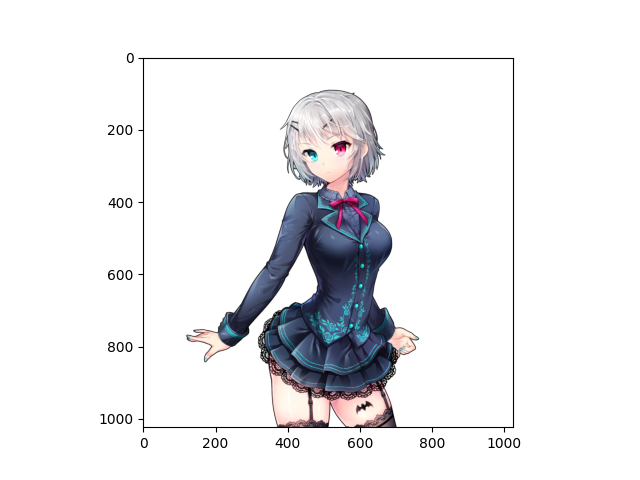

In [8]:
character1_id = int(script['SCRIPT_CHARACTER1_IMG'])
character1_img = get_character_image(character1_id, None)

plt.figure()
plt.imshow(character1_img)

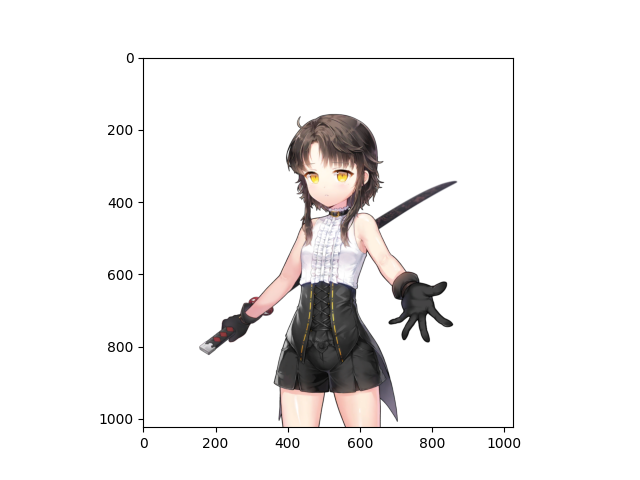

In [9]:
character2_id = int(script['SCRIPT_CHARACTER2_IMG'])
character2_img = get_character_image(character2_id, None)

plt.figure()
plt.imshow(character2_img)

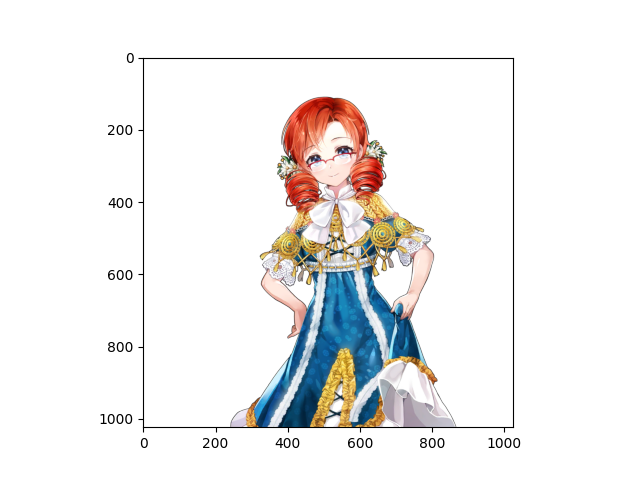

In [10]:
character3_id = int(script['SCRIPT_CHARACTER3_IMG'])
character3_img = get_character_image(character3_id, None)

plt.figure()
plt.imshow(character3_img)

시타
시니아. 이제 가는 거야?


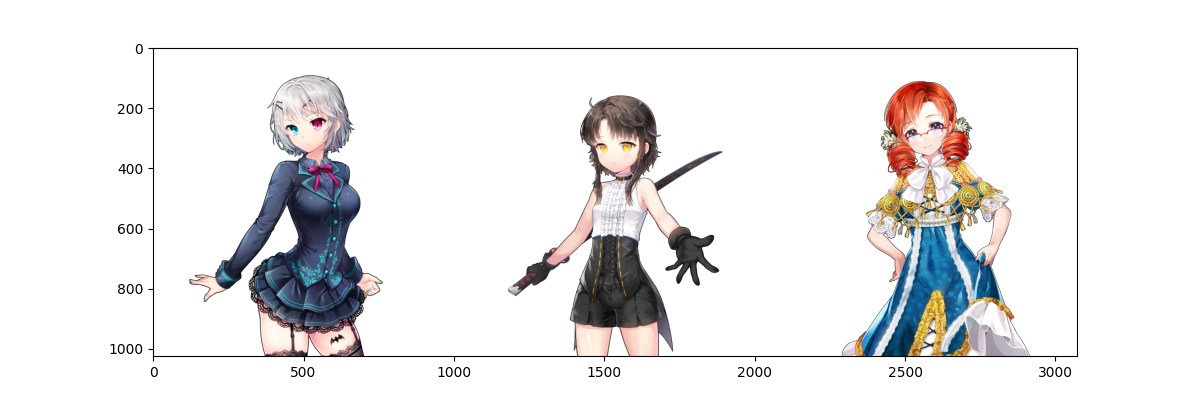

In [11]:
script = scripts_per_floor[0][0]
script_name = string_data.loc[string_data['STRING_NAME'] == script['SCRIPT_NAME']]['STRING_KR'].item()
script_text = string_data.loc[string_data['STRING_NAME'] == script['SCRIPT_TEXT']]['STRING_KR'].item()
print(script_name)
print(script_text)

fimage = get_final_image(character1_img, character2_img, character3_img)

plt.figure(figsize=(12, 4))
plt.imshow(fimage)

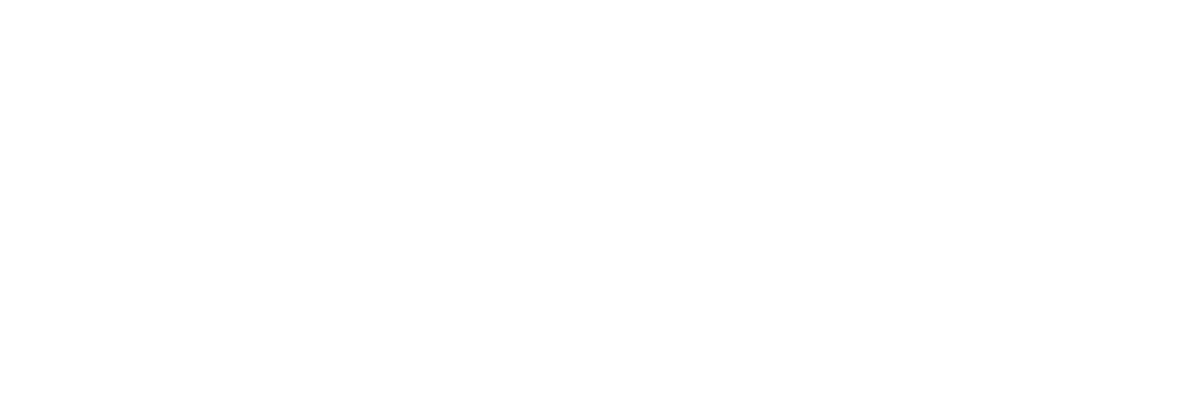

In [251]:
floor = 7
index = 0
fig = plt.figure(figsize=(12, 4))

루티카
당신과 기사단장의 관계에 대해서는 풍문은 들었지만 역시 당사자에게 듣는 게 정확하니까요.


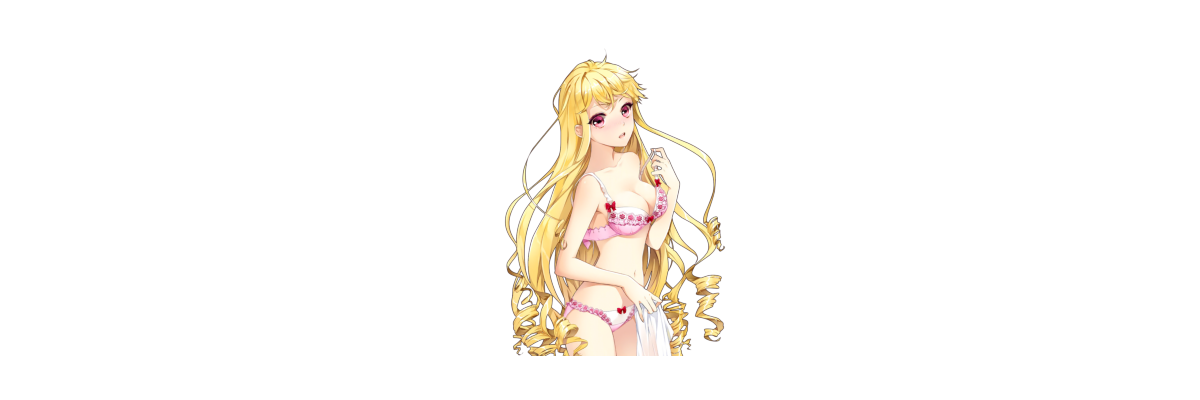

In [292]:
if index >= len(scripts_per_floor[floor]):
    assert 1 == 0, 'Finished'

plt.close(fig)

script = scripts_per_floor[floor][index]
script_name = string_data.loc[string_data['STRING_NAME'] == script['SCRIPT_NAME']]['STRING_KR'].tolist()[0]
script_text = string_data.loc[string_data['STRING_NAME'] == script['SCRIPT_TEXT']]['STRING_KR'].item()
print(script_name)
print(script_text)

cimages = []
for i in ['1', '2', '3']:
    cid = script[f'SCRIPT_CHARACTER{i}_IMG']
    cid = int(cid) if len(cid) != 0 else -1
    dark = script[f'SCRIPT_CHARACTER{i}_DARK']
    cimage = get_character_image(cid, dark)
    cimages.append(cimage)

fimage = get_final_image(*cimages)

fig = plt.figure(figsize=(12, 4))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
ax = fig.add_subplot()
ax.axis('off')
ax.imshow(fimage)

index += 1

In [14]:
index

1